# Neural Machine Translation

###  Predicting Machine Redable dates from Human readable date

For instance, there are variety of possible human readable formats (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"), this network will convert that into standardized, machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24"). The model is run on Google colab with GPU. 

## Importing Packages

In [1]:
pip install Faker

     |████████████████████████████████| 1.0MB 12.5MB/s 


In [2]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

#pip install Faker
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Preparation

Data used for this analysis is from [Faker](https://pypi.org/project/Faker/), a Python package that generates fake data for you. It can generate address, name, text, date etc..

Following are the steps used for data preparation:
1. Fetching data from Faker and creating human readable and machine readable dates.
2. Creating a list of both the dates and dictionary of human vocab and machine vocab by assigning index to each of the unique character/integer.



In [0]:
# Formats consist of all possible formats of date 
FORMATS = ['short','medium','medium','medium','long','long','long','long','long','full','full','full','d MMM YYY',
           'd MMMM YYY','d MMMM YYY','d MMMM YYY','d MMMM YYY','d MMMM YYY','dd/MM/YYY','EE d, MMM YYY','EEEE d, MMMM YYY']

In [0]:
def random_date():
    data = Faker().date_object()

    try:
        date = format_date(data, format=random.choice(FORMATS), locale='en')
        human_date = date.lower().replace(',', '')
        machine_date = data.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_date, machine_date, data

In [0]:

def load_dataset(size):
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    
    '''
    size: Number of instances in the data used for the analysis
    dataset: List of two groups of dates (human readable date, machine readable date)
    human_vocab: mapping of all characters used in human readable dates to dictionary index values
    machine_vocab: mapping of all characters used in machine-readable dates to dictionary index values ​​(not necessarily identical to the index of human_vocab)
    inv_machine_vocab: flip map of machine_vocab, mapping from index to character
    '''
    for i in tqdm(range(size)):
        h, size, _ = random_date()
        if h is not None:
            dataset.append((h, size))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(size))
    
    # Two special characters are added: <unk> for unknown characters in case if the word/character is not in the vocabulary, and <pad> to add padding at the end of the final sequence
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v: k for k, v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [6]:
size = 30000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(size)

100%|██████████| 30000/30000 [06:11<00:00, 80.84it/s]


In [0]:
import pickle 
f = open("human_vocab.pkl","wb")
pickle.dump(human_vocab,f)
f.close()

f = open("inv_machine_vocab.pkl","wb")
pickle.dump(inv_machine_vocab,f)
f.close()

## Data Preprocessing

Here data will be processed by getting indexes corresponding to each of the input date using dictionaries created in previous step. Also, the length of each row in the process data will be of same size using padding. Later, one hot encoding is created for the indexes data.

In [0]:
def string_to_int(string, length, vocab):
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    return rep

In [0]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = np.array([string_to_int(t, Ty, machine_vocab) for t in Y])
    
    X_1 = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Y_1 = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, Y,X_1,Y_1

In [0]:
Tx=30 # Timestep/Length of input date
Ty=10 # Timestep/Length of output date
X,Y,X_1,Y_1 = preprocess_data(dataset,human_vocab,machine_vocab,Tx,Ty)

## Sequence to Sequence Model using Attention Mechanism 

Sequence to Sequence model uses an Bidirectional RNN arcitecture so that the model will have forward and backward information (in the form of activations) at every step so that the model will learn from previous as well later instances. Attention mechanism is used by the network to identify how much focus to be made for one partcular time step as information from multiple time step will be folating into the prediction for that instance. 

A small neural network is used to identify the attention weights using the activation and LSTM layer of the decoder vector. Context is calculated using the attention weights and activated factors which will be passed as the information to the Post-attention LSTM layer of decoder. 

<center>        
<img src="attn_mechanism.png" style="width:500;height:500px;"> 
</center>
<caption><center> **Figure 1**: Atttention Mechanism</center></caption>


In [0]:
# Different layers required for Attention calculation 

repeator     = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1      = Dense(10,activation='tanh')
densor2      = Dense(1,activation='relu')
activator    = Activation('softmax',name="attention_weights")
dotor        = Dot(axes=1)

In [0]:
# Forward Propagation to get one_step_attention() with the layers
def one_step_attention(a,s_prev):
  '''
  Execute attention:
  a      : hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
  s_prev : previous hidden state of the (post-attention) LSTM, numpy-array of shape
  context: context vector, input of the next (post-attention) LSTM cell
  '''
  s_prev=repeator(s_prev)
  concat=concatenator([a,s_prev])
  e=densor1(concat)
  energies=densor2(e)
  alphas=activator(energies)
  context=dotor([alphas,a])
  return context

First getting activation from Bidirectional LSTM, then one_step_attention is performed Ty times to calculate context. Following that another layer of LSTM will predict y.


<center>        
<img src="attn_model.png" style="width:500;height:500px;"> 
</center>
<caption><center> **Figure 2**: Neural machine translation with attention</center></caption>


In [0]:
def model(Tx,Ty,n_a,n_s,human_vocab_size,machine_vocab_size):
    
    '''
    n_a: hidden state size of the Bi-LSTM
    n_s: hidden state size of the post-attention LSTM
    model: Keras model instance
    '''

    X=Input(shape=(Tx,human_vocab_size))
    s0=Input(shape=(n_s,),name='s0')   #  s0,c0 - initial hidden state for the decoder LSTM of shape (n_s,)
    c0=Input(shape=(n_s,),name='c0')
    s=s0
    c=c0
 
    outputs=[]
    a = Bidirectional(LSTM(n_a,return_sequences=True))(X)
    for t in range(Ty):
      context=one_step_attention(a,s)
      s,_,c=post_activation_LSTM_cell(context,initial_state=[s,c])
      out=output_layer(s)
      outputs.append(out)

    model=Model(inputs=[X,s0,c0],outputs=outputs)
 
    return model

In [0]:
n_a = 32 
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation='softmax')

In [0]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

Compiling the model

In [0]:
opt = Adam(lr=0.0005,beta_1=0.9,beta_2=0.999,decay=0.01)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

s0 = np.zeros((size,n_s))
c0 = np.zeros((size,n_s))
outputs = list(Y_1.swapaxes(0,1))

In [17]:
# Input: X, s0, c0 of all training samples (m=10000, Tx=30)
# Output: A list of 11 (m, Ty) elements. So: outputs[i][0], ..., outputs[i][Ty] represents the label characters of the i-th sample (X[i])

history = model.fit([X_1,s0,c0],outputs,epochs=30,batch_size=100)

Epoch 1/30
30000/30000 [==============================] - 50s 2ms/step - loss: 18.4986 - dense_3_loss: 2.5811 - dense_3_accuracy: 0.5893 - dense_3_accuracy_1: 0.7018 - dense_3_accuracy_2: 0.3418 - dense_3_accuracy_3: 0.1241 - dense_3_accuracy_4: 0.6896 - dense_3_accuracy_5: 0.1530 - dense_3_accuracy_6: 0.0567 - dense_3_accuracy_7: 0.7113 - dense_3_accuracy_8: 0.1978 - dense_3_accuracy_9: 0.1079
Epoch 2/30
30000/30000 [==============================] - 44s 1ms/step - loss: 15.1181 - dense_3_loss: 2.2917 - dense_3_accuracy: 0.9397 - dense_3_accuracy_1: 0.9351 - dense_3_accuracy_2: 0.5011 - dense_3_accuracy_3: 0.1584 - dense_3_accuracy_4: 0.8406 - dense_3_accuracy_5: 0.0955 - dense_3_accuracy_6: 0.0743 - dense_3_accuracy_7: 0.5294 - dense_3_accuracy_8: 0.3958 - dense_3_accuracy_9: 0.1953
Epoch 3/30
30000/30000 [==============================] - 43s 1ms/step - loss: 13.9807 - dense_3_loss: 2.1343 - dense_3_accuracy: 0.9636 - dense_3_accuracy_1: 0.9655 - dense_3_accuracy_2: 0.5891 - dense_3

In [0]:
model.save('NMT_date_conversion_model.h5')

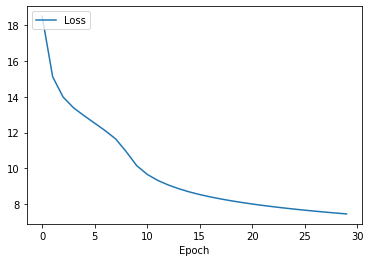

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

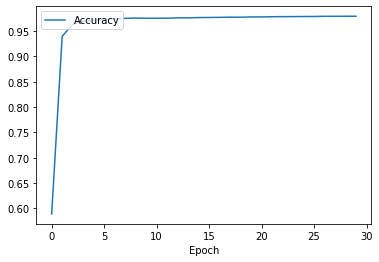

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['dense_3_accuracy'])

plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.show()

## Next Step

- Model can be trained on higher size of data 
- Different parameters can be tried like learning rate, units etc.
- Different optimization function can be tried like LeakyRelu etc. 
- We can play more around the architechure adding more layers. 

